In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from qutip import *
import itertools as it
import matplotlib.pyplot as plt

In [2]:
N=2
trainsize = 10000
testsize = 1000

In [3]:
def experiment(phi,m=100,exact=True):
    #initialization
    res = []
    s = [qeye(2), sigmax(), sigmay(), sigmaz()]
    olist = []
    for i in it.product(range(4), repeat=N):
        temp = []
        for j in i:
            temp.append(s[j])
        tempop = tensor(temp)
        olist.append(tempop)
    if exact:
        res = [expect(o,phi) for o in olist]
    
    else:
        for o in olist:
            vals, vecs = o.eigenstates()
            ps = expect(ket2dm(phi),vecs)
            ps = ps
            out = np.random.choice(vals, m, p=ps)
            res.append(np.mean(out))
    
    return res 

def gen_entangled():
    phi0 = 1/np.sqrt(2)*(tensor([basis(2,0) for dummy in range(N)]) + tensor([basis(2,1) for dummy in range(N)]))
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*phi0 

def gen_prod():
    phi0 = tensor([basis(2,0) for dummy in range(N)])
    U = tensor([rand_unitary(2) for dummy in range(N)])
    return U*phi0

In [4]:
psilisttrain = []
for j in range(trainsize):
    psitemp = rand_ket(2**N)
    psitemp.dims = [[2,2],1]
    psilisttrain.append(psitemp)

In [5]:
ent = [experiment(psi1) for psi1 in psilisttrain]

In [132]:
entangled_data = np.asarray(ent)

In [6]:
prod = [experiment(gen_prod()) for dummy in range(trainsize)]
traindatax = np.concatenate((ent,prod))
traindatay = np.concatenate(([[0,1] for dummy in range(trainsize)],[[1,0] for dummy in range(trainsize)]))

In [143]:
product_data = np.asarray(prod)

In [7]:
enttest = [experiment(gen_entangled()) for dummy in range(testsize)]
prodtest = [experiment(gen_prod()) for dummy in range(testsize)]
testdatax = np.concatenate((enttest,prodtest))
testdatay = np.concatenate(([[0,1] for dummy in range(testsize)],[[1,0] for dummy in range(testsize)]))

In [8]:
randomizer = np.random.permutation(2*trainsize)

In [9]:
np.take(traindatax,randomizer,axis=0,out=traindatax);
np.take(traindatay,randomizer,axis=0,out=traindatay);

In [315]:
x = tf.placeholder(tf.float32, [None, 4**N])
W = tf.Variable(tf.zeros([4**N, 2]))
b = tf.Variable(tf.zeros([2]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 2])

In [316]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=tf.matmul(x, W) + b)

In [317]:
train_step = tf.train.GradientDescentOptimizer(1).minimize(cross_entropy)

In [318]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [319]:
for _ in range(50):
    batch_xs = traindatax[50*_:50*(_+1)]
    batch_ys = traindatay[50*_:50*(_+1)]
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [320]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [321]:
print(sess.run(accuracy, feed_dict={x: testdatax, y_: testdatay}))

0.9985


In [255]:
psi = rand_ket(2**N)
psi.dims = [[2,2],1]

In [256]:
testest = experiment(psi,10)

In [257]:
predict = tf.argmax(y, 1)
pred = predict.eval({x: [testest] })
pred

array([1])

In [337]:
sess.run(W)

array([[-10.93210983,  10.93210983],
       [-16.42613983,  16.42613792],
       [ 12.16604519, -12.16604614],
       [ 17.41062737, -17.41062355],
       [-14.51203251,  14.51203156],
       [-18.08301735,  18.08301735],
       [  2.74268985,  -2.74268985],
       [  1.36852157,  -1.36852181],
       [ 12.37654114, -12.37654114],
       [  0.97745377,  -0.97745353],
       [  6.74898863,  -6.74898767],
       [  5.4740181 ,  -5.4740181 ],
       [ 20.28531456, -20.28531456],
       [  3.34950876,  -3.34950876],
       [  6.39948082,  -6.39947987],
       [  8.71055603,  -8.71055603]], dtype=float32)

In [353]:
sess.run(tf.cast(tf.nn.softmax(tf.convert_to_tensor(np.dot(traindatax[6015],sess.run(W)))),dtype=tf.float32))

array([  1.00000000e+00,   9.80561994e-25], dtype=float32)

# Autoencoder Attempt

In [277]:
# Network Parameters
n_hidden_1 = 4 # 1st layer num features
n_input = 4**N # Input data from all tomography results

In [278]:
X = tf.placeholder(tf.float32, [None, n_input])

In [279]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}

In [280]:
#Build the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    
    return layer_1

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.matmul(x, weights['decoder_h1'])+ biases['decoder_b1'])
    return layer_1

In [281]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

In [282]:
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(.2).minimize(cost)

# Initializing the variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [330]:
for _ in range(2000):
    batch_xs = product_data[50*_:50*(_+1)].astype('float32')
    sess.run(optimizer, feed_dict={X: batch_xs})

In [331]:
print(sess.run(cost, feed_dict={X: testdatax}))

0.149648


In [332]:
print(sess.run(cost, feed_dict={X: testdatax[1000:1999]}))

0.0471815


In [333]:
print(sess.run(cost, feed_dict={X: testdatax[0:999]}))

0.252153


In [434]:
sess.run(decoder(encoder(test32))[150]-test32[150])

array([ -5.00679016e-06,   4.13769996e-03,   3.29462975e-01,
        -3.68526876e-01,   1.32720008e-01,   1.05668034e-03,
         1.86496868e-03,   1.47092074e-01,  -2.85472274e-02,
         9.40828249e-02,   4.17127103e-01,   4.07491326e-02,
         3.97621989e-02,   7.87324563e-04,   4.89653587e-01,
        -2.63677329e-01], dtype=float32)

In [301]:
test32=tf.cast(testdatax,'float32')

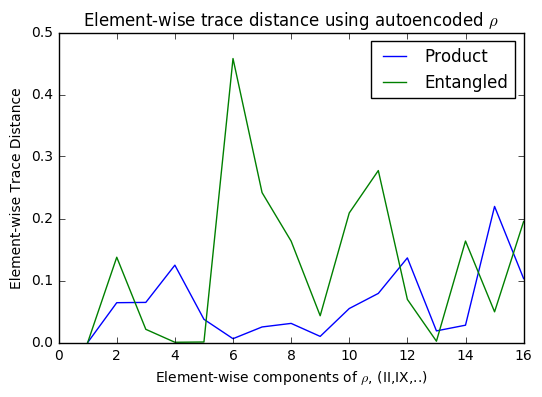

In [518]:
plt.plot(index,np.average((sess.run(X-decoder(encoder(X)),feed_dict={X: testdatax[1000:1999]}))**2,0),label='Product')
plt.plot(index,np.average((sess.run(X-decoder(encoder(X)),feed_dict={X: testdatax[0:999]}))**2,0),label='Entangled')
plt.ylabel('Element-wise Trace Distance')
plt.xlabel('Element-wise components of '+r'$\rho$'+', (II,IX,..)')
plt.title('Element-wise trace distance using autoencoded '+r'$\rho$')
plt.legend()

In [497]:
np.average(np.average((sess.run(X-decoder(encoder(X)),feed_dict={X: testdatax[0:999]}))**2,0))

0.12703079

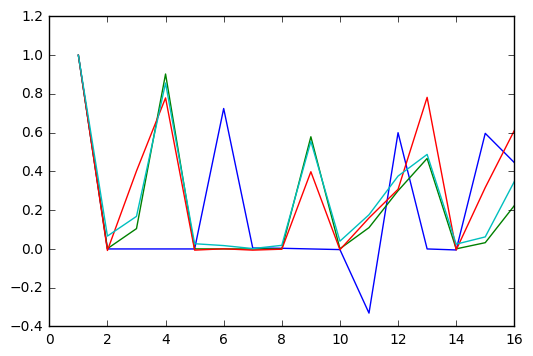

In [336]:
plt.plot(visible_index,np.average(sess.run(X,feed_dict={X: testdatax[0:999]}),0),
         visible_index,np.average(sess.run(decoder(encoder(X)),feed_dict={X: testdatax[0:999]}),0),
        visible_index,np.average(sess.run(X,feed_dict={X: testdatax[1000:1999]}),0),
         visible_index,np.average(sess.run(decoder(encoder(X)),feed_dict={X: testdatax[1000:1999]}),0),
       visible_index,sess.run(decoder())

In [288]:
visible_index = np.arange(1,17)
hidden_index = np.arange(1,5)

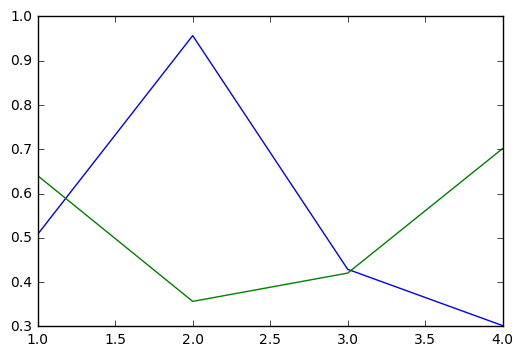

In [315]:
plt.plot(hidden_index,np.average(sess.run(encoder(X),feed_dict={X: testdatax[0:999]}),0),
        hidden_index,np.average(sess.run(encoder(X),feed_dict={X: testdatax[1000:1999]}),0))

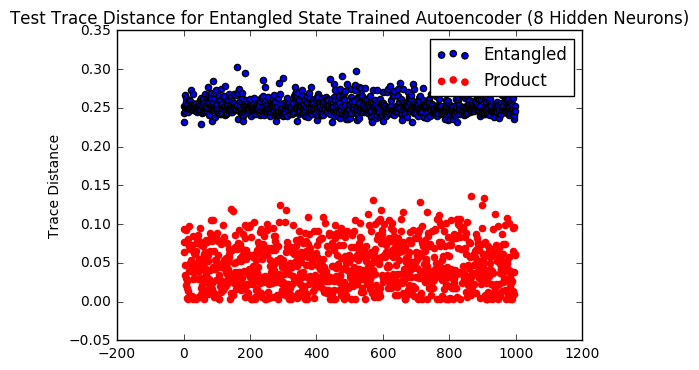

In [334]:
plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: testdatax[0:999]}),
            label='Entangled')
plt.scatter(scatter_index,sess.run(tf.reduce_mean(tf.pow(y_true - y_pred, 2),1),feed_dict={X: testdatax[1000:1999]}),
            color='r',label='Product')
plt.legend()
plt.ylabel('Trace Distance')
plt.title('Test Trace Distance for Entangled State Trained Autoencoder (8 Hidden Neurons)')

In [29]:
testdatax[1]

array([  1.00000000e+00,   5.55111512e-17,   4.16333634e-17,
         5.55111512e-17,  -2.77555756e-17,   2.48570762e-01,
        -9.67436055e-01,  -4.77499301e-02,  -2.77555756e-17,
        -9.06847394e-01,  -2.49759143e-01,   3.39482215e-01,
         5.55111512e-17,   3.40353317e-01,   4.10834533e-02,
         9.39399686e-01])

In [38]:
scatter_index = np.arange(0,999)

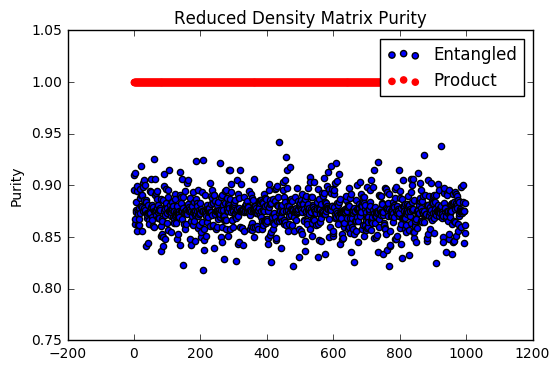

In [335]:
plt.scatter(scatter_index,1-0.125*(testdatax[1000:1999,2]**2+testdatax[1000:1999,3]**2+testdatax[1000:1999,4]**2)
            ,label='Entangled')
plt.scatter(scatter_index,1-0.125*(testdatax[0:999,2]**2+testdatax[0:999,3]**2+testdatax[0:999,4]**2),
            label='Product',color='r')
plt.legend()
plt.title('Reduced Density Matrix Purity')
plt.ylabel('Purity')

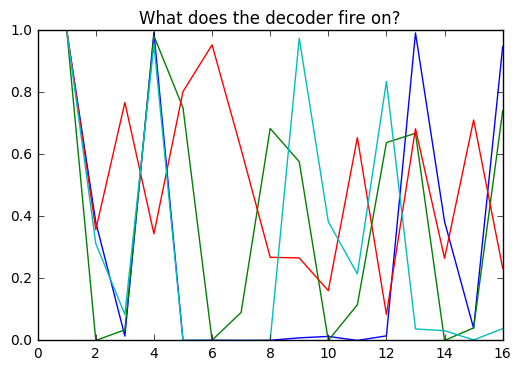

In [357]:
plt.plot(visible_index,sess.run(decoder(np.asarray([[1.0,0.0,0.0,0.0]]).astype('float32')))[0],
        visible_index,sess.run(decoder(np.asarray([[0.0,1.0,0.0,0.0]]).astype('float32')))[0],
        visible_index,sess.run(decoder(np.asarray([[0.0,0.0,1.0,0.0]]).astype('float32')))[0],
        visible_index,sess.run(decoder(np.asarray([[0.0,0.0,0.0,1.0]]).astype('float32')))[0])
plt.title('What does the decoder fire on?')